# Distributionally Robust Kelly Optimization - Demo

This notebook demonstrates the core functionality of the `kelly_robust` package:

1. **Classical Kelly** - the optimal fraction when parameters are known
2. **Plug-in Kelly** - naive estimation leads to overbetting
3. **DRK (Distributionally Robust Kelly)** - principled robustness
4. **ACK (Adaptive Conformal Kelly)** - data-driven calibration

Author: Agna Chan  
Date: December 2025


In [1]:
# Setup
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Reproducibility
np.random.seed(42)

print('Setup complete!')


Setup complete!


## 1. Classical Kelly Criterion

The Kelly criterion maximizes the expected log-growth rate:

$$f^* = \frac{\mu - r}{\sigma^2}$$

where $\mu$ is the expected return, $r$ is the risk-free rate, and $\sigma^2$ is the variance.


In [2]:
from kelly_robust.core.kelly import kelly_single_asset, growth_rate_gaussian

# True parameters (daily returns)
TRUE_MU = 0.0005      # ~12.6% annualized
TRUE_SIGMA = 0.02     # ~31.7% annualized vol
TRUE_SIGMA2 = TRUE_SIGMA**2
RISK_FREE = 0.0001    # ~2.5% annualized

# Oracle Kelly fraction
f_oracle = kelly_single_asset(TRUE_MU, TRUE_SIGMA2, RISK_FREE)

print(f"True parameters:")
print(f"  μ = {TRUE_MU:.6f} daily ({TRUE_MU * 252:.2%} annualized)")
print(f"  σ = {TRUE_SIGMA:.6f} daily ({TRUE_SIGMA * np.sqrt(252):.2%} annualized)")
print(f"  r = {RISK_FREE:.6f} daily ({RISK_FREE * 252:.2%} annualized)")
print(f"\nOracle Kelly fraction: {f_oracle:.4f}")


True parameters:
  μ = 0.000500 daily (12.60% annualized)
  σ = 0.020000 daily (31.75% annualized)
  r = 0.000100 daily (2.52% annualized)

Oracle Kelly fraction: 1.0000


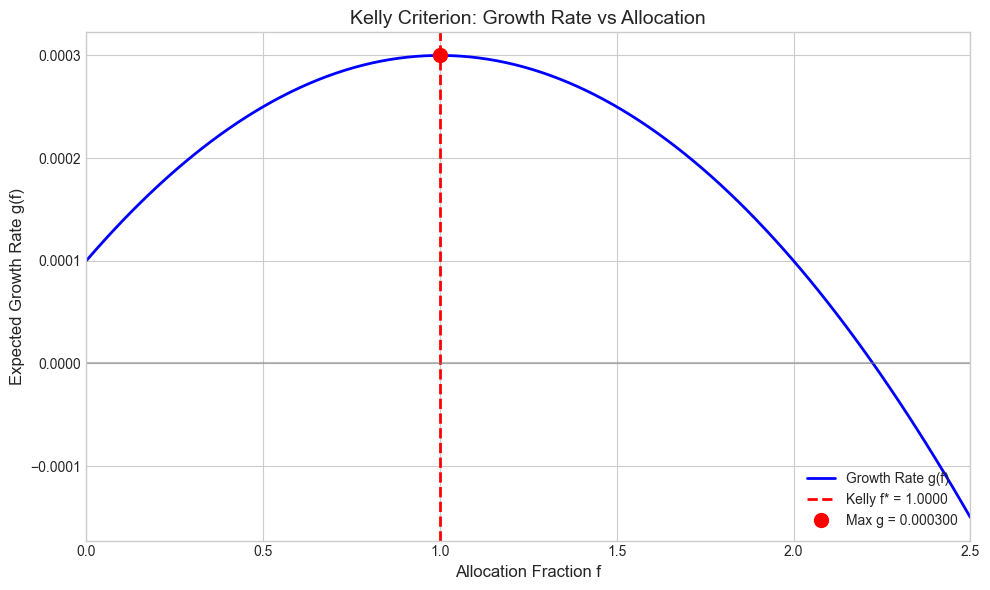

In [3]:
# Visualize growth rate as a function of allocation fraction
fractions = np.linspace(0, 2.5, 100)
growth_rates = [growth_rate_gaussian(f, TRUE_MU, TRUE_SIGMA2, RISK_FREE) for f in fractions]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fractions, growth_rates, 'b-', linewidth=2, label='Growth Rate g(f)')
ax.axvline(f_oracle, color='r', linestyle='--', linewidth=2, label=f'Kelly f* = {f_oracle:.4f}')
ax.axhline(0, color='gray', linestyle='-', alpha=0.5)

# Mark the optimal point
g_optimal = growth_rate_gaussian(f_oracle, TRUE_MU, TRUE_SIGMA2, RISK_FREE)
ax.plot(f_oracle, g_optimal, 'ro', markersize=10, label=f'Max g = {g_optimal:.6f}')

ax.set_xlabel('Allocation Fraction f', fontsize=12)
ax.set_ylabel('Expected Growth Rate g(f)', fontsize=12)
ax.set_title('Kelly Criterion: Growth Rate vs Allocation', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.set_xlim([0, 2.5])
plt.tight_layout()
plt.show()


## 2. The Estimation Problem

In practice, we don't know μ and σ². We estimate them from data. The **plug-in Kelly** fraction is problematic because:
1. Estimation error in μ̂ is magnified by division
2. Overbetting is more harmful than underbetting (Kelly is concave)


In [4]:
from kelly_robust.core.kelly import simulate_gbm_returns

# Generate sample data (1 year of daily returns)
sample_size = 252
returns = simulate_gbm_returns(TRUE_MU, TRUE_SIGMA, sample_size, seed=123)

# Estimate parameters
mu_hat = np.mean(returns)
sigma2_hat = np.var(returns, ddof=1)

# Plug-in Kelly
f_plugin = kelly_single_asset(mu_hat, sigma2_hat, RISK_FREE)

print(f"Sample size: {sample_size} days")
print(f"\nEstimated parameters:")
print(f"  μ̂ = {mu_hat:.6f} (true: {TRUE_MU:.6f}, error: {(mu_hat-TRUE_MU)/TRUE_MU:+.1%})")
print(f"  σ̂² = {sigma2_hat:.8f} (true: {TRUE_SIGMA2:.8f}, error: {(sigma2_hat-TRUE_SIGMA2)/TRUE_SIGMA2:+.1%})")
print(f"\nPlug-in Kelly: {f_plugin:.4f} (oracle: {f_oracle:.4f})")


Sample size: 252 days

Estimated parameters:
  μ̂ = 0.000105 (true: 0.000500, error: -79.0%)
  σ̂² = 0.00041921 (true: 0.00040000, error: +4.8%)

Plug-in Kelly: 0.0121 (oracle: 1.0000)


## 3. Distributionally Robust Kelly (DRK)

DRK accounts for estimation uncertainty by considering a worst-case distribution:

$$f^{\text{DRK}} = \frac{\hat{\mu} - r - \varepsilon}{\hat{\sigma}^2}$$

where ε is the ambiguity radius calibrated via conformal prediction.


In [5]:
from kelly_robust.core.kelly import drk_single_asset_closed_form, adaptive_conformal_kelly

# DRK with standard error-based epsilon
se = np.sqrt(sigma2_hat / sample_size)
epsilon_se = 1.645 * se  # 90% confidence

f_drk = drk_single_asset_closed_form(
    mu_hat, sigma2_hat, epsilon_se, RISK_FREE,
    min_fraction=0, max_fraction=1
)

# ACK (Adaptive Conformal Kelly)
ack_result = adaptive_conformal_kelly(
    returns, RISK_FREE, alpha=0.1, 
    split_ratio=0.5, min_fraction=0, max_fraction=1
)

print(f"Standard Error: {se:.6f}")
print(f"Epsilon (SE-based): {epsilon_se:.6f}")
print(f"Epsilon (Conformal): {ack_result.epsilon:.6f}")
print(f"\nKelly fractions:")
print(f"  Oracle:  {f_oracle:.4f}")
print(f"  Plug-in: {f_plugin:.4f}")
print(f"  Half:    {0.5*f_plugin:.4f}")
print(f"  DRK:     {f_drk:.4f}")
print(f"  ACK:     {ack_result.fraction:.4f}")


Standard Error: 0.001290
Epsilon (SE-based): 0.002122
Epsilon (Conformal): 0.029859

Kelly fractions:
  Oracle:  1.0000
  Plug-in: 0.0121
  Half:    0.0061
  DRK:     0.0000
  ACK:     0.0000


## 4. Monte Carlo Comparison

Let's compare these strategies across many simulations.


In [6]:
from kelly_robust.core.kelly import run_kelly_comparison

# Run comparison
print("Running Monte Carlo comparison (1000 simulations)...")
results = run_kelly_comparison(
    true_mu=TRUE_MU,
    true_sigma=TRUE_SIGMA,
    sample_size=252,
    horizon=252,
    n_simulations=1000,
    risk_free=RISK_FREE,
    alpha=0.1,
    seed=42
)
print("Done!")

# Display results
print("\n" + "=" * 80)
print(f"{'Strategy Comparison (1-Year Horizon)':^80}")
print("=" * 80)
print(f"{'Strategy':<12} {'Mean f':>10} {'Mean W_T':>12} {'Med W_T':>10} {'Mean log(W)':>12} {'P(profit)':>10}")
print("-" * 80)

for strategy in ['oracle', 'plugin', 'half', 'drk', 'ack']:
    r = results[strategy]
    print(f"{strategy:<12} {r['mean_fraction']:>10.4f} {r['mean_terminal_wealth']:>12.4f} "
          f"{r['median_terminal_wealth']:>10.4f} {r['mean_log_wealth']:>12.4f} {r['prob_profit']:>10.2%}")

print("=" * 80)


Running Monte Carlo comparison (1000 simulations)...


Done!

                      Strategy Comparison (1-Year Horizon)                      
Strategy         Mean f     Mean W_T    Med W_T  Mean log(W)  P(profit)
--------------------------------------------------------------------------------
oracle           1.0000       1.1145     1.0660       0.0568     58.10%
plugin           0.5178       1.0664     1.0255       0.0385     76.80%
half             0.2589       1.0456     1.0255       0.0381     79.90%
drk              0.0528       1.0274     1.0255       0.0247     97.00%
ack              0.0000       1.0255     1.0255       0.0252    100.00%


## 5. Key Insights

**Observations:**
1. **Plug-in Kelly** has higher mean wealth but worse median and higher variance
2. **DRK and ACK** sacrifice some mean wealth for better median performance and lower risk
3. **Half-Kelly** is a reasonable heuristic, but DRK/ACK provide theoretical justification

**Core Insight:** Kelly cares about **log-wealth**, not wealth. DRK/ACK optimize this more reliably.
